In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

In [2]:
#loading datasets
orders = pd.read_csv('../input/solutechclustering/orders.csv')
shops = pd.read_csv('../input/solutechclustering/shops.csv')

print('Loaded!')

Loaded!


In [3]:
# function to reduce memory usage 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
#reduce memory for orders dataset
orders = reduce_mem_usage(orders)

Memory usage of dataframe is 937.63 MB
Memory usage after optimization is: 431.23 MB
Decreased by 54.0%


In [5]:
#views shops dataframe 
shops.head(3)

,SHOPID,SHOP_NAME,LATITUDE,LONGITUDE
0,408821,Point one retail and wholesale,-1.288216,36.904458
1,408820,Masai junior shop,-1.252627,36.908463
2,408819,Maasai junior shop,-1.251378,36.916290


In [6]:
#map the areas using folium 
import folium
import geopy

In [7]:
shop_mapping = folium.Map(location=[shops.LATITUDE.mean(), shops.LONGITUDE.mean()], zoom_start=14, control_scale=True)
for index, location_info in shops.iterrows():
    folium.Marker([location_info["LATITUDE"], location_info["LONGITUDE"]], popup=location_info["SHOP_NAME"]).add_to(shop_mapping)

In [8]:
#view our map
shop_mapping

In [9]:
orders.head(3)

,VISITID,ENTRY_ID,ENTRY_TYPE,USERID,SALES_REP,REP_CATEGORY,SUPERVISOR,SHOPID,CUSTOMER_ERP_CODE,CUSTOMER_NAME,CUSTOMER_ACCOUNT,USERCATEGORY,CUSTOMER_ADDED_DATE,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_ID,LOCATION_NAME,TERRITORY_ID,TERRITORY_NAME,ROUTE_NAME,REGION_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,PIECES_SOLD,CARTONS_SOLD,VALUE_SOLD,ENTRY_TIME
0,NaN,1239693,Sale,25,ALEX OKETCH ODIPO,Van-Sellers,SUPERVISOR,143707,143707,JOSE,NaN,Van-Sellers,2018-08-13 14:49:26,Pending,WHOLESALERS,0.0,NaN,NaN,NaN,KISUMU - UGUNJA,EASTERN,FRESH 10S ACTIVE,FRESH 10S ACTIVE,FRESH WATERMELON 8 TRAYS X 30 X10 PCS,40.0,5.0,10800.0,2019-01-07 14:51:31
1,NaN,1239693,Sale,25,ALEX OKETCH ODIPO,Van-Sellers,SUPERVISOR,143707,143707,JOSE,NaN,Van-Sellers,2018-08-13 14:49:26,Pending,WHOLESALERS,0.0,NaN,NaN,NaN,KISUMU - UGUNJA,EASTERN,FRESH 10S,FRESH 10S,FRESH MENTHOL 8 TRAYS X 30 X10 PCS,40.0,5.0,10800.0,2019-01-07 14:51:31
2,NaN,1239693,Sale,25,ALEX OKETCH ODIPO,Van-Sellers,SUPERVISOR,143707,143707,JOSE,NaN,Van-Sellers,2018-08-13 14:49:26,Pending,WHOLESALERS,0.0,NaN,NaN,NaN,KISUMU - UGUNJA,EASTERN,FRESH 10S,FRESH 10S,FRESH FRUITY 8 TRAYS X 30 X10 PCS,40.0,5.0,10800.0,2019-01-07 14:51:31


In [10]:
# limit our study to Nairobi region
ord_nrb = orders[orders['REGION_NAME']=='NAIROBI']
ord_nrb.shape

(1224561, 28)

In [11]:
ord_nrb.head(3)

,VISITID,ENTRY_ID,ENTRY_TYPE,USERID,SALES_REP,REP_CATEGORY,SUPERVISOR,SHOPID,CUSTOMER_ERP_CODE,CUSTOMER_NAME,CUSTOMER_ACCOUNT,USERCATEGORY,CUSTOMER_ADDED_DATE,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_ID,LOCATION_NAME,TERRITORY_ID,TERRITORY_NAME,ROUTE_NAME,REGION_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,PIECES_SOLD,CARTONS_SOLD,VALUE_SOLD,ENTRY_TIME
26670,NaN,1243905,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,SUPERVISOR,238808,238808,BRINGBRING,NaN,FootSoldiers - Brilliantdom,2018-12-04 04:58:15,Valid,SHOP,117.0,KIBERA,NaN,NaN,OLYMPIC/AYANY,NAIROBI,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 08:03:09
26671,NaN,1245619,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,SUPERVISOR,238815,238815,BOYO,NaN,FootSoldiers - Brilliantdom,2018-12-04 05:07:49,Pending,SHOP,117.0,KIBERA,NaN,NaN,OLYMPIC/AYANY,NAIROBI,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 10:14:17
26672,NaN,1248165,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,SUPERVISOR,238825,238825,SIMO,NaN,FootSoldiers - Brilliantdom,2018-12-04 05:24:44,Pending,SHOP,117.0,KIBERA,NaN,NaN,OLYMPIC/AYANY,NAIROBI,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 12:22:04


In [12]:
ord_nrb['REGION_NAME'].nunique()

1

In [13]:
ord_nrb.reset_index(drop=True,inplace=True)


In [14]:
ord_nrb.head(3)

,VISITID,ENTRY_ID,ENTRY_TYPE,USERID,SALES_REP,REP_CATEGORY,SUPERVISOR,SHOPID,CUSTOMER_ERP_CODE,CUSTOMER_NAME,CUSTOMER_ACCOUNT,USERCATEGORY,CUSTOMER_ADDED_DATE,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_ID,LOCATION_NAME,TERRITORY_ID,TERRITORY_NAME,ROUTE_NAME,REGION_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,PIECES_SOLD,CARTONS_SOLD,VALUE_SOLD,ENTRY_TIME
0,NaN,1243905,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,SUPERVISOR,238808,238808,BRINGBRING,NaN,FootSoldiers - Brilliantdom,2018-12-04 04:58:15,Valid,SHOP,117.0,KIBERA,NaN,NaN,OLYMPIC/AYANY,NAIROBI,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 08:03:09
1,NaN,1245619,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,SUPERVISOR,238815,238815,BOYO,NaN,FootSoldiers - Brilliantdom,2018-12-04 05:07:49,Pending,SHOP,117.0,KIBERA,NaN,NaN,OLYMPIC/AYANY,NAIROBI,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 10:14:17
2,NaN,1248165,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,SUPERVISOR,238825,238825,SIMO,NaN,FootSoldiers - Brilliantdom,2018-12-04 05:24:44,Pending,SHOP,117.0,KIBERA,NaN,NaN,OLYMPIC/AYANY,NAIROBI,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 12:22:04


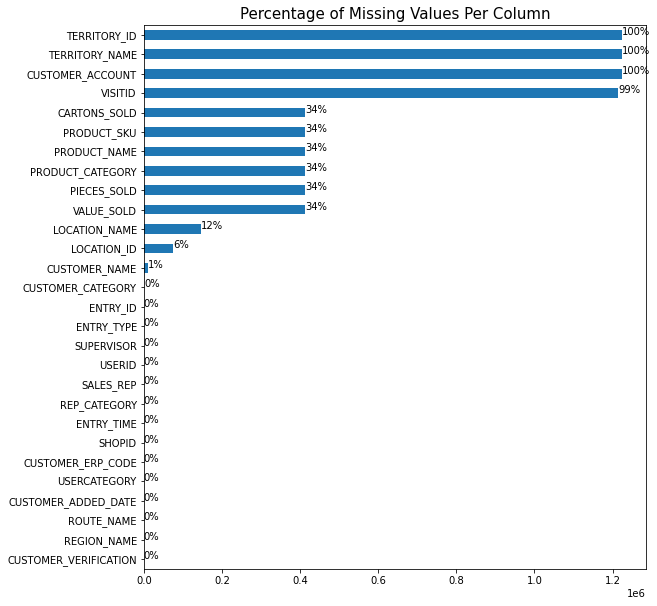

In [15]:
# Check if there any missing values in shops
ax = ord_nrb.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/ord_nrb.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [16]:
# drop some columns 
ord_nrb.drop(['VISITID','SUPERVISOR','CUSTOMER_ERP_CODE','TERRITORY_ID','TERRITORY_NAME','CUSTOMER_ACCOUNT','REGION_NAME'],axis=1,inplace=True)

In [17]:
# filling in the missing values 
ord_nrb['PRODUCT_CATEGORY'].fillna(ord_nrb['PRODUCT_CATEGORY'].mode()[0],inplace=True)
ord_nrb['PRODUCT_NAME'].fillna(ord_nrb['PRODUCT_NAME'].mode()[0],inplace=True)
ord_nrb['PRODUCT_SKU'].fillna(ord_nrb['PRODUCT_SKU'].mode()[0],inplace=True)

ord_nrb['PIECES_SOLD'].fillna(0,inplace=True)
ord_nrb['CARTONS_SOLD'].fillna(0,inplace=True)
ord_nrb['VALUE_SOLD'].fillna(0,inplace=True)

ord_nrb['CUSTOMER_NAME'].fillna(ord_nrb['CUSTOMER_NAME'].mode()[0],inplace=True)
ord_nrb['CUSTOMER_CATEGORY'].fillna(ord_nrb['CUSTOMER_CATEGORY'].mode()[0],inplace=True)
ord_nrb['LOCATION_NAME'].fillna(ord_nrb['LOCATION_NAME'].mode()[0],inplace=True)
ord_nrb['LOCATION_ID'].fillna(ord_nrb['LOCATION_ID'].mode()[0],inplace=True)
ord_nrb.isnull().sum().sum()

0

In [18]:
#Number of unique sales representatives in Nairobi County
ord_nrb['SALES_REP'].nunique()

427

In [19]:
#Supervisor Sales by Customer Category
sales_sup =ord_nrb.pivot_table(index='SALES_REP', columns='CUSTOMER_CATEGORY',values='VALUE_SOLD')

In [20]:
sales_sup.head()

CUSTOMER_CATEGORY,KIOSKS,MINI MARKET,SHOP,SUPERMARKET,TABLE TOPS,WHOLESALERS
SALES_REP,,,,,,
ACHIENG BEATRICE,185.689651,132.500000,162.482162,NaN,195.000000,192.593979
ADHIAMBO BEATRICE,0.000000,NaN,12.121212,83.333336,NaN,NaN
AGGREY KISANYA,98.171242,NaN,102.541946,NaN,115.551109,92.379501
AGNES MUTUA,70.054344,28.333334,56.389706,55.833332,68.750000,75.648148
AGNES OKETCH,7550.541504,3890.847412,5516.593750,5360.231445,5243.200195,5287.132812


In [21]:
ord_nrb.describe(include=['category'])

,ENTRY_TYPE,SALES_REP,REP_CATEGORY,CUSTOMER_NAME,USERCATEGORY,CUSTOMER_ADDED_DATE,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_NAME,ROUTE_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,ENTRY_TIME
count,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561
unique,4,427,19,52787,19,90854,3,6,164,1109,17,60,173,912050
top,Sale,LILIAN MBULA,FootSoldiers - Brilliantdom,BARAKA,FootSoldiers - Brilliantdom,2018-05-09 10:14:58,Pending,SHOP,NAIROBI CBD,PARK ROAD,FRESH 4S,FRESH 4S,TING TINGS STRAWBERRY BBG 12 PKTS X 50Pc,2019-04-13 15:44:51
freq,759271,42065,470712,15219,470712,4589,933305,842736,226431,15943,794591,794591,479905,32


In [22]:

threshold = 1000 # Anything that occurs less than this will be removed.
value_counts = ord_nrb['LOCATION_NAME'].value_counts() # Entire DataFrame 
to_remove = value_counts[value_counts <= threshold].index
ord_nrb['LOCATION_NAME'].replace(to_remove, np.nan, inplace=True)

In [23]:
ord_nrb.describe(include=['category'])

,ENTRY_TYPE,SALES_REP,REP_CATEGORY,CUSTOMER_NAME,USERCATEGORY,CUSTOMER_ADDED_DATE,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_NAME,ROUTE_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,ENTRY_TIME
count,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1224561,1215184,1224561,1224561,1224561,1224561,1224561
unique,4,427,19,52787,19,90854,3,6,64,1109,17,60,173,912050
top,Sale,LILIAN MBULA,FootSoldiers - Brilliantdom,BARAKA,FootSoldiers - Brilliantdom,2018-05-09 10:14:58,Pending,SHOP,NAIROBI CBD,PARK ROAD,FRESH 4S,FRESH 4S,TING TINGS STRAWBERRY BBG 12 PKTS X 50Pc,2019-04-13 15:44:51
freq,759271,42065,470712,15219,470712,4589,933305,842736,226431,15943,794591,794591,479905,32


In [24]:
ord_nrb['LOCATION_NAME'].value_counts()

NAIROBI CBD    226431
GITHURAI        63291
UMOJA           53851
KAWANGWARE      46373
KIAMBU          45173
                ...  
MAREBA           1876
SHAURI MOYO      1491
MADARAKA         1216
BAHATI           1163
HAMZA            1130
Name: LOCATION_NAME, Length: 64, dtype: int64

In [25]:
# group sales by location 
ord_nrb.groupby(['LOCATION_NAME'])['VALUE_SOLD'].mean().sort_values(ascending=False)

LOCATION_NAME
TASSIA           1137.524048
RUIRU             882.216736
NAIROBI CBD       855.642517
LIMURU            788.450684
UTHIRU            735.772278
                    ...     
HAMZA             109.815041
JERUSALEM         105.850166
GITHOGORO         100.588501
MOMBASA C.B.D     100.571465
MATHARE            84.556686
Name: VALUE_SOLD, Length: 64, dtype: float32

In [26]:
#USERCATEGORY
ord_nrb['USERCATEGORY'].equals(ord_nrb['REP_CATEGORY'])

True

In [27]:
# drop one column 
orders.drop(['REP_CATEGORY'],axis=1,inplace=True)

In [28]:
# group sales by location 
ord_nrb.groupby(['REP_CATEGORY'])['VALUE_SOLD'].mean().sort_values(ascending=False)

REP_CATEGORY
Kenafric Industries            7760.486328
Wholesale Champions            6764.887207
Tuk Tuk                        2303.075928
Beverage Presellers            1804.692749
KCP POS                         883.713440
Tassia KCP                      433.041626
Motorbike - BrilliantDom        285.759705
TRADCO MBSR                     233.973282
FootSoldiers - IM Salaried      210.298096
Kawangware KCP                  207.052719
FootSoldiers - TRADCO           180.291183
Test Agency                     178.333328
Baba Dogo KCP                   169.459885
FootSoldiers - Brilliantdom     140.222733
FRESH ACTIVE TEAM               126.414581
JILAG                           113.883423
ADSUM VENTURES                   54.504715
ICL Uganda                       52.917389
FootSoldiers - AV                52.296436
BISCUIT PRESELLERS                     NaN
Van-Sellers                            NaN
Name: VALUE_SOLD, dtype: float32

In [29]:
orders['ENTRY_TYPE'].replace({'0':'Sale'}, inplace = True)

In [30]:
ord_nrb.groupby(['ENTRY_TYPE'])['VALUE_SOLD'].mean().sort_values(ascending=False)

ENTRY_TYPE
Order    7063.690430
Sale      278.493927
skip        0.000412
0           0.000000
Name: VALUE_SOLD, dtype: float32

In [31]:
ord_nrb.groupby(['CUSTOMER_VERIFICATION'])['VALUE_SOLD'].mean().sort_values(ascending=False)

CUSTOMER_VERIFICATION
Pending    530.981445
Valid      310.437836
Invalid    160.378433
Name: VALUE_SOLD, dtype: float32

In [32]:
ord_nrb.head(3)

,ENTRY_ID,ENTRY_TYPE,USERID,SALES_REP,REP_CATEGORY,SHOPID,CUSTOMER_NAME,USERCATEGORY,CUSTOMER_ADDED_DATE,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_ID,LOCATION_NAME,ROUTE_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,PIECES_SOLD,CARTONS_SOLD,VALUE_SOLD,ENTRY_TIME
0,1243905,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,238808,BRINGBRING,FootSoldiers - Brilliantdom,2018-12-04 04:58:15,Valid,SHOP,117.0,KIBERA,OLYMPIC/AYANY,FRESH 4S,FRESH 4S,TING TINGS STRAWBERRY BBG 12 PKTS X 50Pc,0.0,0.0,0.0,2019-01-08 08:03:09
1,1245619,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,238815,BOYO,FootSoldiers - Brilliantdom,2018-12-04 05:07:49,Pending,SHOP,117.0,KIBERA,OLYMPIC/AYANY,FRESH 4S,FRESH 4S,TING TINGS STRAWBERRY BBG 12 PKTS X 50Pc,0.0,0.0,0.0,2019-01-08 10:14:17
2,1248165,skip,38,MILDRED MUSINGA NAOMI,FootSoldiers - Brilliantdom,238825,SIMO,FootSoldiers - Brilliantdom,2018-12-04 05:24:44,Pending,SHOP,117.0,KIBERA,OLYMPIC/AYANY,FRESH 4S,FRESH 4S,TING TINGS STRAWBERRY BBG 12 PKTS X 50Pc,0.0,0.0,0.0,2019-01-08 12:22:04


In [33]:
ord_nrb.shape

(1224561, 21)

In [34]:
ord_nrb.to_csv('nairobi_sales.csv')

In [35]:
# attempting clustering 
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

clus = ord_nrb[['PIECES_SOLD','CARTONS_SOLD','VALUE_SOLD']]
#Clus_dataSet = np.nan_to_num(Clus_dataSet)
#Clus_dataSet = np.array(Clus_dataSet, dtype=np.float64)
Clus_dataSet = StandardScaler().fit_transform(clus)

In [36]:
Clus_dataSet

array([[-0.3337336 , -0.08339726, -0.10931834],
       [-0.3337336 , -0.08339726, -0.10931834],
       [-0.3337336 , -0.08339726, -0.10931834],
       ...,
       [-0.07527021, -0.03974696, -0.05432367],
       [-0.07527021, -0.03974696, -0.05661512],
       [-0.07527021, -0.03974696, -0.05661512]], dtype=float32)

In [37]:
from sklearn.cluster import KMeans #K-Means

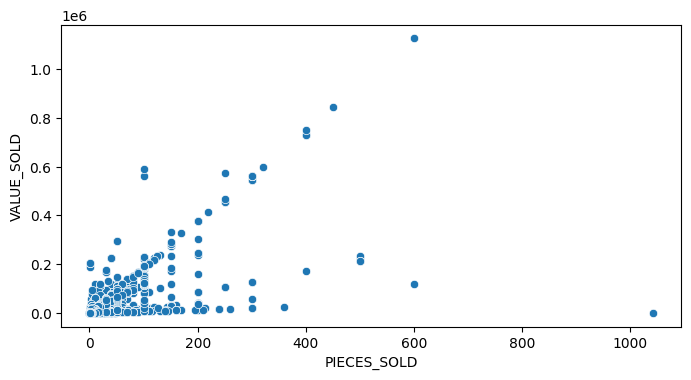

In [38]:
#scatter plot
plt.figure(figsize = (8,4), dpi = 100)
sns.scatterplot(data=clus,x='PIECES_SOLD',y='VALUE_SOLD')
plt.show()

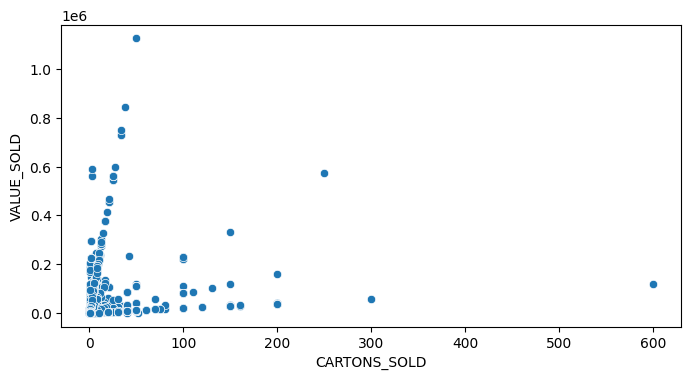

In [39]:
#scatter plot
plt.figure(figsize = (8,4), dpi = 100)
sns.scatterplot(data=clus,x='CARTONS_SOLD',y='VALUE_SOLD')
plt.show()

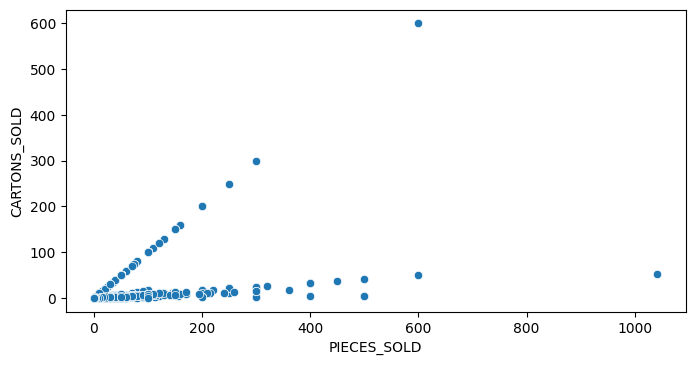

In [40]:
#scatter plot
plt.figure(figsize = (8,4), dpi = 100)
sns.scatterplot(data=clus,x='PIECES_SOLD',y='CARTONS_SOLD')
plt.show()

In [41]:
#define the function 
def display_categories(model,data):
    labels = model.fit_predict(data)
    plt.figure(figsize = (8,4), dpi = 100)
    sns.scatterplot(data=data,x='VALUE_SOLD',y='PIECES_SOLD',hue=labels,palette='Set1')
    plt.show()

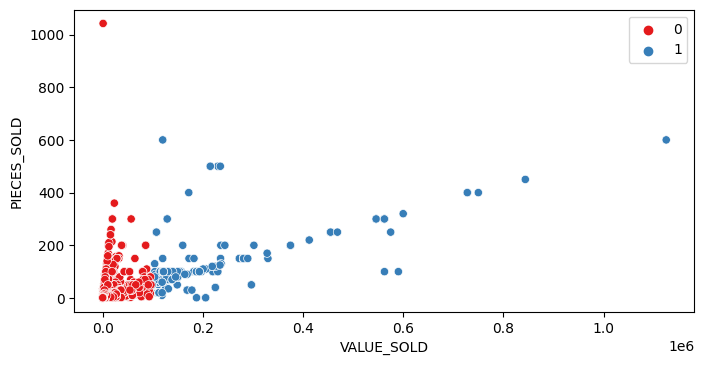

In [42]:
#intiate the model
model = KMeans(n_clusters = 2)
display_categories(model,clus)

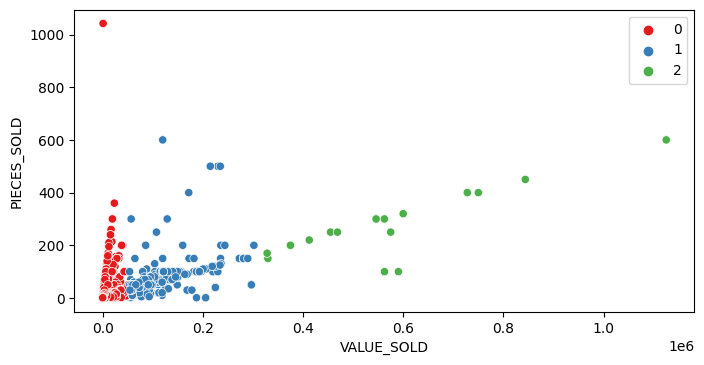

In [43]:
#intiate the model
model = KMeans(n_clusters = 3)
display_categories(model,clus)

In [44]:
# Tassia Mappings 
df = pd.merge(ord_nrb,shops, on='SHOPID')

In [45]:
df.to_csv('tassia_mappings.csv')

In [46]:
#Performing RFM 
#Extracting R (Recency), F (Frequency), M (Monetary) columns form the data.
# Monetary Function
# Finding total amount spent per shop
monetary = df.groupby("SHOPID").VALUE_SOLD.sum()
monetary = monetary.reset_index()
monetary.head()

,SHOPID,VALUE_SOLD
0,243861,28220.0
1,243864,24965.0
2,243905,9045.0
3,243942,7575.0
4,244089,4335.0


In [47]:
#Frequency function

# Getting the count of customer verification made by each shop based on SHOPID.
frequency = df.groupby("SHOPID").CUSTOMER_VERIFICATION.count()
frequency = frequency.reset_index()
frequency.head()

,SHOPID,CUSTOMER_VERIFICATION
0,243861,75
1,243864,74
2,243905,63
3,243942,55
4,244089,46


In [48]:
df.drop(['CUSTOMER_ADDED_DATE'],axis=1,inplace=True)

In [49]:
#creating master dataset
master = monetary.merge(frequency, on = "SHOPID", how = "inner")
master.head()

,SHOPID,VALUE_SOLD,CUSTOMER_VERIFICATION
0,243861,28220.0,75
1,243864,24965.0,74
2,243905,9045.0,63
3,243942,7575.0,55
4,244089,4335.0,46


In [50]:
# parse date
df['ENTRY_TIME'] = pd.to_datetime(df['ENTRY_TIME'],infer_datetime_format = True, utc = True).astype('datetime64[ns]')

In [51]:
# Finding max data
maximum = max(df.ENTRY_TIME)

In [52]:
# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days = 1)

In [53]:
df['DIFF'] = maximum - df['ENTRY_TIME']
df.head()

,ENTRY_ID,ENTRY_TYPE,USERID,SALES_REP,REP_CATEGORY,SHOPID,CUSTOMER_NAME,USERCATEGORY,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_ID,LOCATION_NAME,ROUTE_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,PIECES_SOLD,CARTONS_SOLD,VALUE_SOLD,ENTRY_TIME,SHOP_NAME,LATITUDE,LONGITUDE,DIFF
0,1305822,Sale,77,ROBERT MUGAMBI,FootSoldiers - Brilliantdom,243861,SOFT SHOP,FootSoldiers - Brilliantdom,Valid,SHOP,137.0,TASSIA,TASSIA,FRESH 4S,FRESH 4S,FRESH MENTHOL 12BAGS X 50PCS,1.0,0.083313,180.0,2019-01-14 10:00:45,soft shop,-1.307511,36.899044,351 days 08:45:56
1,1305822,Sale,77,ROBERT MUGAMBI,FootSoldiers - Brilliantdom,243861,SOFT SHOP,FootSoldiers - Brilliantdom,Valid,SHOP,137.0,TASSIA,TASSIA,FRESH 4S,FRESH 4S,FRESH FRUIT 12BAGS X 50PCS,1.0,0.083313,180.0,2019-01-14 10:00:45,soft shop,-1.307511,36.899044,351 days 08:45:56
2,1305822,Sale,77,ROBERT MUGAMBI,FootSoldiers - Brilliantdom,243861,SOFT SHOP,FootSoldiers - Brilliantdom,Valid,SHOP,137.0,TASSIA,TASSIA,FRESH 4S,FRESH 4S,FRESH STRAWBERRY 12BAGS X 50PCS,1.0,0.083313,180.0,2019-01-14 10:00:45,soft shop,-1.307511,36.899044,351 days 08:45:56
3,1374743,skip,77,ROBERT MUGAMBI,FootSoldiers - Brilliantdom,243861,SOFT SHOP,FootSoldiers - Brilliantdom,Valid,SHOP,137.0,TASSIA,TASSIA,FRESH 4S,FRESH 4S,TING TINGS STRAWBERRY BBG 12 PKTS X 50Pc,0.0,0.000000,0.0,2019-01-21 08:52:10,soft shop,-1.307511,36.899044,344 days 09:54:31
4,1450700,Sale,77,ROBERT MUGAMBI,FootSoldiers - Brilliantdom,243861,SOFT SHOP,FootSoldiers - Brilliantdom,Valid,SHOP,137.0,TASSIA,TASSIA,FRESH 4S,FRESH 4S,FRESH MENTHOL 12BAGS X 50PCS,1.0,0.083313,165.0,2019-01-28 10:05:46,soft shop,-1.307511,36.899044,337 days 08:40:55


In [54]:
#Recency Value
#Dataframe merging by recency
recency = df.groupby('SHOPID')['DIFF'].min()
recency = recency.reset_index()
recency.head()

,SHOPID,DIFF
0,243861,1 days 00:09:19
1,243864,1 days 00:00:00
2,243905,7 days 23:14:10
3,243942,7 days 22:46:27
4,244089,162 days 04:09:52


In [55]:
#RFM combined DataFrame
#Combining all recency, frequency and monetary parameters
RFM = master.merge(recency, on = "SHOPID")
RFM.columns = ['SHOPID','VALUE_SOLD','FREQUENCY','RECENCY']
RFM.head()

,SHOPID,VALUE_SOLD,FREQUENCY,RECENCY
0,243861,28220.0,75,1 days 00:09:19
1,243864,24965.0,74,1 days 00:00:00
2,243905,9045.0,63,7 days 23:14:10
3,243942,7575.0,55,7 days 22:46:27
4,244089,4335.0,46,162 days 04:09:52


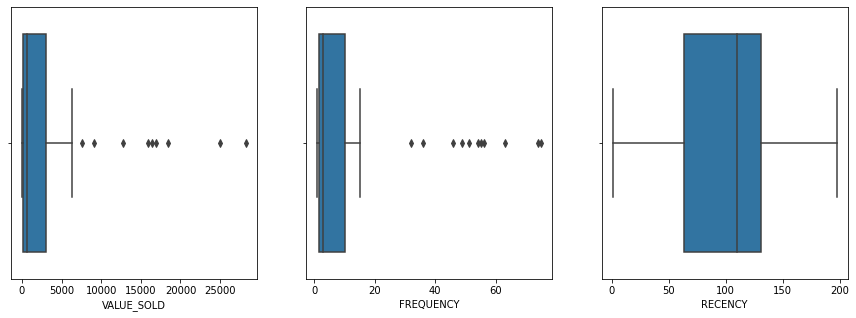

In [56]:
#Outlier Treatment
import seaborn as sns 
# outlier treatment for VALUE_SOLD.
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.VALUE_SOLD, ax = axs[0])
sns.boxplot(RFM.FREQUENCY, ax = axs[1])
sns.boxplot(RFM.RECENCY.dt.days, ax = axs[2])

plt.tight_layout
plt.show()

In [57]:
# outlier treatment for VALUE_SOLD
Q1 = RFM.VALUE_SOLD.quantile(0.25)
Q3 = RFM.VALUE_SOLD.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.VALUE_SOLD >= Q1 - 1.5*IQR) & (RFM.VALUE_SOLD <= Q3 + 1.5*IQR)]

In [58]:
# outlier treatment for FREQUENCY
Q1 = RFM.FREQUENCY.quantile(0.25)
Q3 = RFM.FREQUENCY.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.FREQUENCY >= Q1 - 1.5*IQR) & (RFM.FREQUENCY <= Q3 + 1.5*IQR)]

In [59]:
#Scaling the RFM data
# standardise all parameters
RFM_norm1 = RFM.drop("SHOPID", axis=1)
RFM_norm1.RECENCY = RFM_norm1.RECENCY.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [60]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['FREQUENCY','VALUE_SOLD','RECENCY']
RFM_norm1.head()

,FREQUENCY,VALUE_SOLD,RECENCY
0,3.979839,2.310231,-1.358088
1,-0.362698,-0.324243,-0.066023
2,-0.027789,0.202652,-0.066023
3,-0.313779,0.202652,-0.066023
4,1.345718,0.992994,-0.102939


In [61]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

hopkins(RFM_norm1)

0.8095813659642154

In [62]:
from sklearn.metrics import silhouette_score
# To perform KMeans clustering 
from sklearn.cluster import KMeans
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

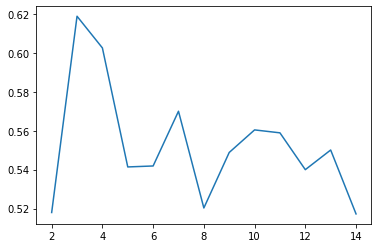

In [63]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

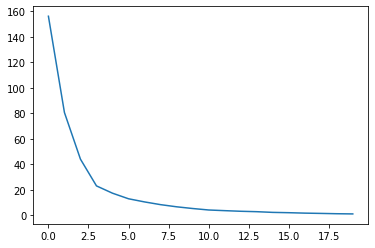

In [64]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=100)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [65]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 4, max_iter=100)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=100, n_clusters=4)

In [66]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['SHOPID', 'VALUE_SOLD', 'FREQUENCY', 'RECENCY', 'CLUSTERID']
RFM_km.head()

,SHOPID,VALUE_SOLD,FREQUENCY,RECENCY,CLUSTERID
0,408687,6265.0,13,75 days 03:21:03,1
1,408704,495.0,3,110 days 05:39:44,3
2,408706,940.0,5,110 days 05:37:30,0
3,408708,560.0,5,110 days 04:06:11,0
4,408709,2765.0,8,109 days 23:31:26,0


In [67]:
RFM_km.RECENCY = RFM_km.RECENCY.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["CLUSTERID"]).VALUE_SOLD.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["CLUSTERID"]).FREQUENCY.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["CLUSTERID"]).RECENCY.mean())

In [68]:
df_rfm = pd.concat([pd.Series([0,1,2,3]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df_rfm.columns = ["CLUSTERID", "VALUE_SOLD_MEAN", "FREQUENCY_MEAN", "RECENCY_MEAN"]
df_rfm.head()

,CLUSTERID,VALUE_SOLD_MEAN,FREQUENCY_MEAN,RECENCY_MEAN
0,0,1446.666626,7.666667,112.75000
1,1,4417.000000,12.200000,80.00000
2,2,269.166656,2.333333,55.00000
3,3,335.862061,1.827586,128.62069


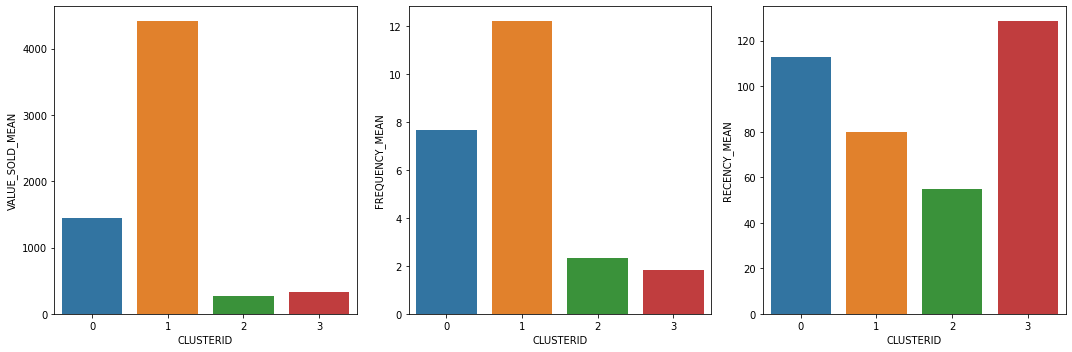

In [69]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.barplot(x=df_rfm.CLUSTERID, y=df_rfm.VALUE_SOLD_MEAN, ax = axs[0])
sns.barplot(x=df_rfm.CLUSTERID, y=df_rfm.FREQUENCY_MEAN, ax = axs[1])
sns.barplot(x=df_rfm.CLUSTERID, y=df_rfm.RECENCY_MEAN, ax = axs[2])
plt.tight_layout()            
plt.show()

In [70]:
df.head(2)

,ENTRY_ID,ENTRY_TYPE,USERID,SALES_REP,REP_CATEGORY,SHOPID,CUSTOMER_NAME,USERCATEGORY,CUSTOMER_VERIFICATION,CUSTOMER_CATEGORY,LOCATION_ID,LOCATION_NAME,ROUTE_NAME,PRODUCT_CATEGORY,PRODUCT_NAME,PRODUCT_SKU,PIECES_SOLD,CARTONS_SOLD,VALUE_SOLD,ENTRY_TIME,SHOP_NAME,LATITUDE,LONGITUDE,DIFF
0,1305822,Sale,77,ROBERT MUGAMBI,FootSoldiers - Brilliantdom,243861,SOFT SHOP,FootSoldiers - Brilliantdom,Valid,SHOP,137.0,TASSIA,TASSIA,FRESH 4S,FRESH 4S,FRESH MENTHOL 12BAGS X 50PCS,1.0,0.083313,180.0,2019-01-14 10:00:45,soft shop,-1.307511,36.899044,351 days 08:45:56
1,1305822,Sale,77,ROBERT MUGAMBI,FootSoldiers - Brilliantdom,243861,SOFT SHOP,FootSoldiers - Brilliantdom,Valid,SHOP,137.0,TASSIA,TASSIA,FRESH 4S,FRESH 4S,FRESH FRUIT 12BAGS X 50PCS,1.0,0.083313,180.0,2019-01-14 10:00:45,soft shop,-1.307511,36.899044,351 days 08:45:56


In [71]:
import pandas as pd
import plotly.express as px
from sklearn.cluster import DBSCAN

anomaly = DBSCAN(eps=0.5, min_samples=6).fit(df[['LONGITUDE','LATITUDE']])

fig1 = px.scatter(df, x="LONGITUDE", y="LATITUDE", color="VALUE_SOLD")
fig1.show()

In [72]:
#state['sales'] = state['geolocation_city'].map(geolocation['geolocation_city'].value_counts())
fig2 = px.density_mapbox(df, lat='LATITUDE', lon='LONGITUDE', z='VALUE_SOLD', radius=50, zoom=12,
                        hover_name="LOCATION_NAME", mapbox_style="stamen-toner")
fig2.show()

In [73]:

clustering2 = DBSCAN(eps=0.014, min_samples=15).fit(df[['LONGITUDE','LATITUDE']])
x = lambda x: "noise" if x == -1 else str(x)
df['clusters_BDSCAN'] = list(map(x,list(clustering2.labels_)))
fig3 = px.scatter_mapbox(df[df['clusters_BDSCAN'] != 'noise'], lat="LATITUDE", lon="LONGITUDE",
                        color="clusters_BDSCAN", title='DBSCAN 0.5eps', hover_data=["VALUE_SOLD"],
                        hover_name="LOCATION_NAME",zoom=11,
                        width=1000, height=500, mapbox_style="stamen-toner")
fig3.show()

In [74]:
!pip install hdbscan

     |████████████████████████████████| 5.2 MB 515 kB/s 
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | / done
    Preparing wheel metadata ... - \ | / - \ done
     |████████████████████████████████| 15.7 MB 58.3 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2444938 sha256=2e89ab3abaed611e00056a88369f4912d3be7caf26fe2634bc33661fca9cd899
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
caip-notebooks-serverextension 1.0.0 requires google-cloud-b

In [75]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=70, gen_min_span_tree=True)
clusterer.fit(df[['LONGITUDE','LATITUDE']])
df['clusters_HDBSCAN'] = list(map(x,list(clusterer.labels_)))
fig4 = px.scatter_mapbox(df[df['clusters_HDBSCAN'] != 'noise'], lat="LATITUDE", lon="LONGITUDE",
                        color="clusters_HDBSCAN", title="HDBSCAN", zoom=11,
                        hover_name="LOCATION_NAME", hover_data=["VALUE_SOLD"],
                        width=1000, height=500, mapbox_style="stamen-toner")
fig4.show()

In [76]:
from sklearn.cluster import OPTICS
clust = OPTICS(min_samples=70, xi=.06, min_cluster_size=.06)
clust.fit(df[['LONGITUDE','LATITUDE']])
df['clusters_OPTICS'] = list(map(x,list(clust.labels_)))
fig5 = px.scatter_mapbox(df[df['clusters_OPTICS'] != 'noise'], lat="LATITUDE", lon="LONGITUDE",
                        color="clusters_OPTICS", title="OPTICS", hover_name="LOCATION_NAME", hover_data=["VALUE_SOLD"],
                        zoom=10, width=1000, height=500, mapbox_style="stamen-toner")
fig5.show()

In [77]:
from sklearn import metrics

clusters_DBSCAN = df[df['clusters_BDSCAN'] != 'noise']
clusters_HDBSCAN = df[df['clusters_HDBSCAN'] != 'noise']
clusters_OPTICS = df[df['clusters_OPTICS'] != 'noise']

print("Silhouette Score")
print("BDSCAN: ",metrics.silhouette_score(clusters_DBSCAN[['LONGITUDE','LATITUDE']],
                                          clusters_DBSCAN['clusters_BDSCAN']))
print("HDBSCAN: ",metrics.silhouette_score(clusters_HDBSCAN[['LONGITUDE','LATITUDE']],
                                           clusters_HDBSCAN['clusters_HDBSCAN']))
print("OPTICS: ",metrics.silhouette_score(clusters_OPTICS[['LONGITUDE','LATITUDE']],
                                          clusters_OPTICS['clusters_OPTICS']))

Silhouette Score
BDSCAN:  0.7681213147140856
HDBSCAN:  0.8642073528168591
OPTICS:  0.8230006956252017


In [78]:
print("Davies Bouldin Score")
print("DBSCAN: ",metrics.davies_bouldin_score(clusters_DBSCAN[['LONGITUDE','LATITUDE']],
                                              clusters_DBSCAN['clusters_BDSCAN']))
print("HDBSCAN: ",metrics.davies_bouldin_score(clusters_HDBSCAN[['LONGITUDE','LATITUDE']],
                                               clusters_HDBSCAN['clusters_HDBSCAN']))
print("OPTICS: ",metrics.davies_bouldin_score(clusters_OPTICS[['LONGITUDE','LATITUDE']],
                                              clusters_OPTICS['clusters_OPTICS']))

Davies Bouldin Score
DBSCAN:  0.278818983704407
HDBSCAN:  0.27394908920842276
OPTICS:  0.33936386599141377
